In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# Vectorize Vertex PCA and Spektral

### KERNEL --> Spektral 
### Classifier --> Spektral
### Node_features = Vectorize Vertex PCA (n_bits = 9,11,13,15,17)

In [3]:
import load_data as ld
import utilities as ut
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from eden.graph import vertex_vectorize


from sklearn.decomposition import TruncatedSVD
from scipy.sparse import vstack
import time

In [11]:
name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR
name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
n_times = 5
pca_n_components = [250,300,500]
bits = [9,11,13,15,17]

acc, loss = run(name,bits,n_times,pca_n_components,complexity = 2,prot=True)

# Results


 LEUKEMUA


/home/antonio/anaconda3/envs/tesi/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antonio/anaconda3/envs/tesi/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


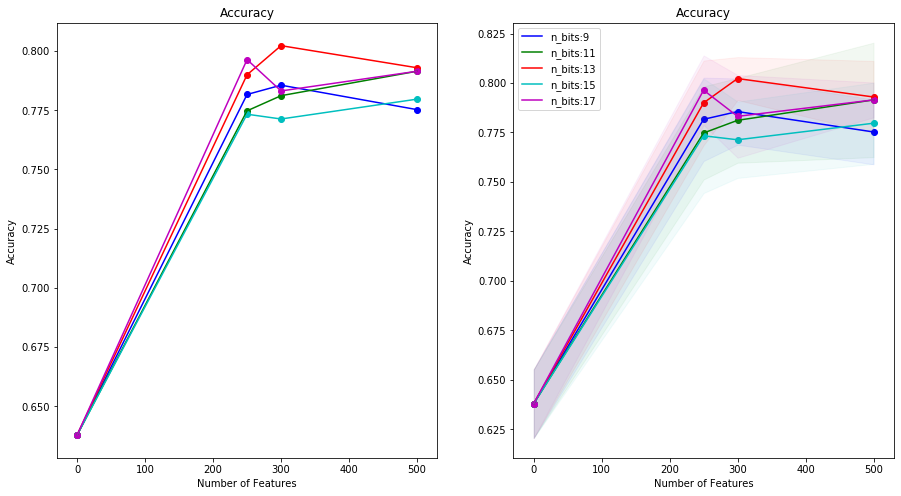


 CANCER


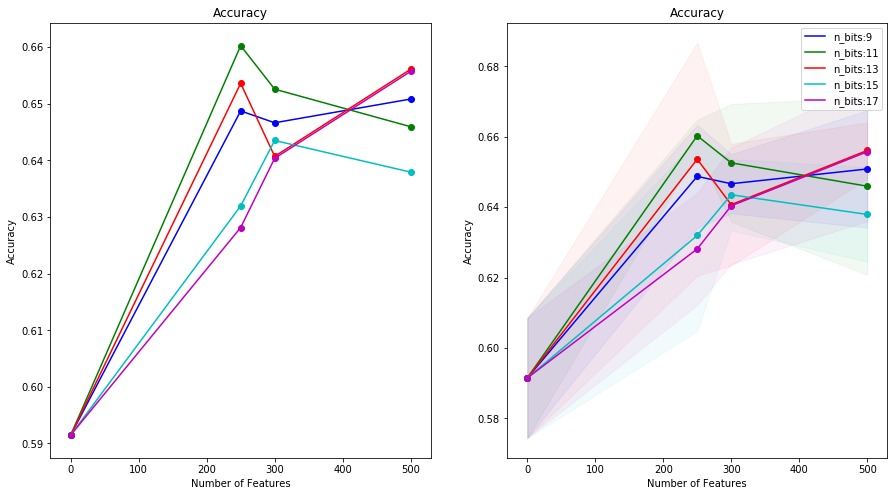


 AIDS


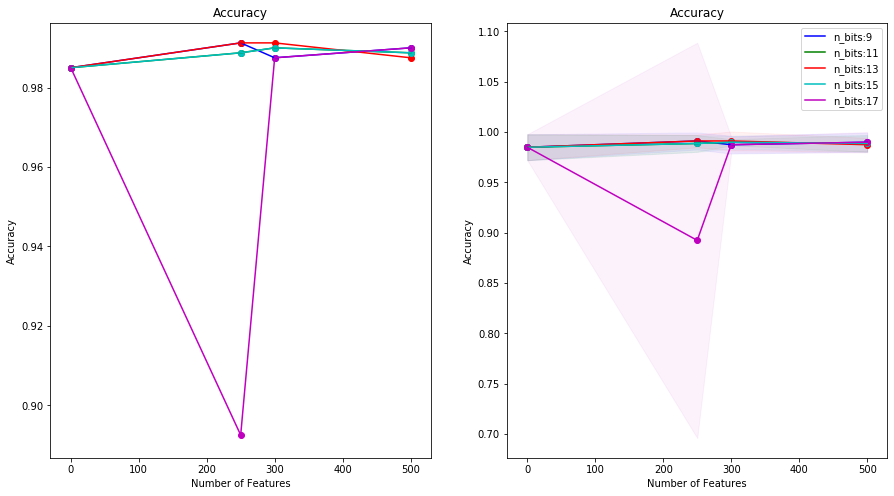


 DHFR


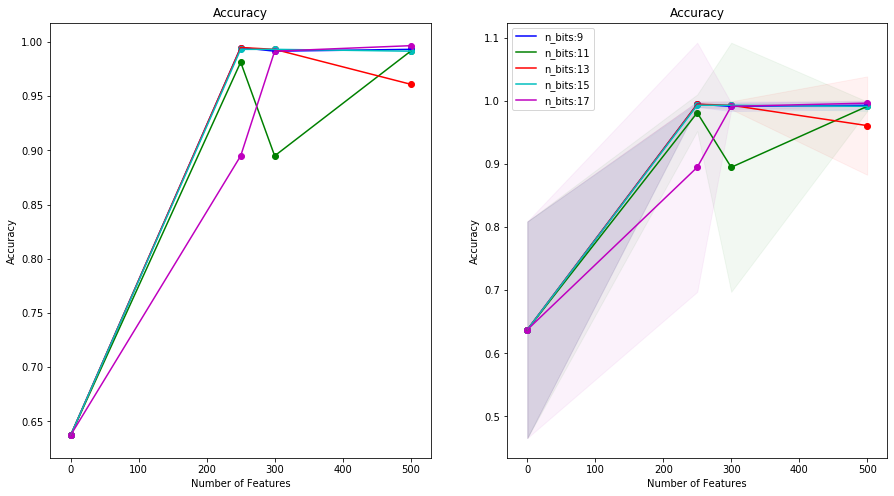


 PROTEINS


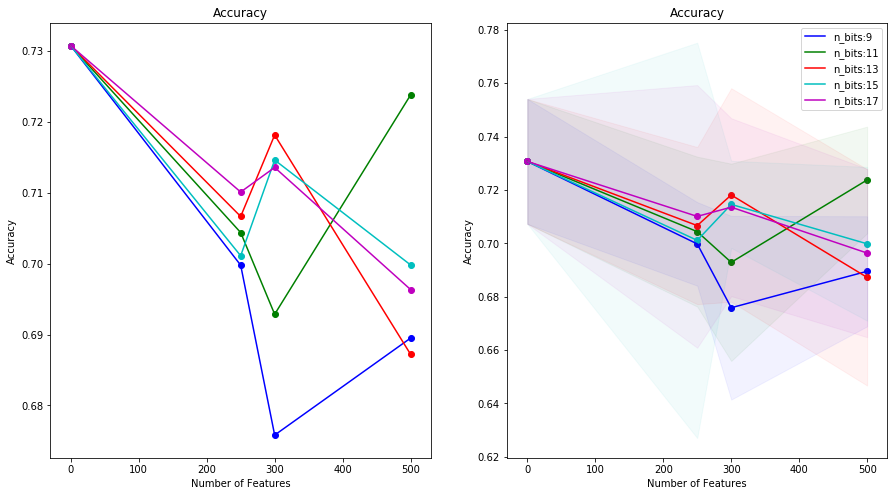

In [14]:
# results
print("\n LEUKEMUA")
plot_nbits_ncoponents(acc_leuk_spk_pca,bits,pca_n_components)
print("\n CANCER")
plot_nbits_ncoponents(acc_canc_spk_pca,bits,pca_n_components)
print("\n AIDS")
plot_nbits_ncoponents(acc_aids_spk_pca,bits,pca_n_components)
print("\n DHFR")
plot_nbits_ncoponents(acc_dhfr_spk_pca,bits,pca_n_components)
print("\n PROTEINS")
plot_nbits_ncoponents(acc_prot_spk_pca,bits,pca_n_components)

In [10]:
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

from spektral.datasets import delaunay
from spektral.layers import GraphAttention, GlobalAvgPool
from spektral.utils import localpooling_filter

def plot_nbits_ncoponents(acc,bits,pca_n_components,text="Accuracy"):

    orig = acc[0]
    accs = acc[1:]

    means = []
    stds = []
    for i in accs:

        metric = i
        mean = [np.mean(orig)]
        std = [np.std(orig)]
        for i in metric:
            mean.append(np.mean(i))
            std.append(np.std(i))

        means.append(mean)
        stds.append(std)
        
        
    plt.figure(figsize=(15,8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    pca_n_components = [0] + pca_n_components
    for i in range(len(means)):
        mean = means[i]
        std = stds[i]
        plt.subplot(121)
        plt.title(text)
        plt.plot(pca_n_components,mean,color=colors[i])
        plt.scatter(pca_n_components,mean,color=colors[i])
        plt.xlabel("Number of Features")
        plt.ylabel("Accuracy")

        plt.subplot(122)
        plt.title(text)
        lab = 'n_bits:'+str(bits[i])
        plt.plot(pca_n_components,mean, label=lab,color=colors[i])
        plt.scatter(pca_n_components,mean,color=colors[i])
        low = [mean[i]-std[i] for i in range(0,len(mean))] 
        upp = [mean[i]+std[i] for i in range(0,len(mean))]
        plt.fill_between(pca_n_components,low,upp, alpha=0.05,color=colors[i])
        plt.xlabel("Number of Features")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.show()

In [5]:
def PCA_vertex(graphs,X,pca_n_components,complexity=2):
    
    # fit transform pca
    pca = TruncatedSVD(n_components=pca_n_components)
    X_res = pca.fit_transform(X)
    
    # add info
    counter = 0
    for g in graphs:
        for node in g.nodes():
            vec = g.nodes[node]['vec']
            new_vec = vec
            for i in X_res[counter]:
                new_vec.append(i)
                
            g.nodes[node]['vec'] = new_vec
            counter = counter + 1

    return(graphs)


In [6]:
def compute_best_acc(acc):
    
    r = np.max(acc[1:],axis=0)
    best = [acc[0]]
    for i in r:
        best.append(list(i))

    return(best)

from tabulate import tabulate


def summary(metric_orig,n_bits,pca_components,return_matrix=False):
    acc =metric_orig[1:]
    mean_vec = []
    std_vec = []
    for vec in acc:
        mean_pca = []
        std_pca = []
        for pca in vec:
            mean_pca.append(np.mean(pca))
            std_pca.append(np.std(pca))

        mean_vec.append(mean_pca)
        std_vec.append(std_pca)
        
        
    if (return_matrix):
        return(mean_vec)
    else:
        new_mean_vec = []
        c = 0
        for i in mean_vec:
            tmp = ["n_bits: "+str(n_bits[c])]
            c = c + 1
            for e in i:
                tmp.append(e)
            new_mean_vec.append(tmp) 


        text_pca_ncomp = []
        for i in pca_components:
            text_pca_ncomp.append("PCA n_comp-"+str(i))
        print(tabulate(new_mean_vec, headers=["VECT"]+text_pca_ncomp))


In [7]:
import networkx as nx
def remove_big_graphs(graphs_in,labels_in):
    grpahs_in = np.array(graphs_in)
    print("sto eliminado i grafi grandi")
    graphs = []
    labels = []
    for j in range(len(graphs_in)):
        n_nodes = graphs_in[j].number_of_nodes() 
        if (n_nodes < 150):
            graphs.append(graphs_in[j])
            labels.append(labels_in[j])
    print(len(graphs))
    graphs = np.array(graphs)
    labels = np.array(labels)
    return(graphs,labels)

In [8]:
import numpy as np 
import copy

def run(name,bits,n_times,pca_n_components,complexity = 2,prot=False):

    acc = []
    loss = []
    
    graphs,labels = ld.load_data_pubchem(name)
    if(prot == True):
        graphs,labels = remove_big_graphs(graphs,labels)
        
    func = [ut.degree, ut.clust_coefficient]
    graphs = ut.add_info_to_nodes(graphs,func,param=None)
    print("no Vectorize:")
    res_acc, res_loss = repeat_n_times(graphs,labels,n_times)
    acc.append(res_acc)
    loss.append(res_loss)
    print(acc)
    
    for i in bits:
        acc_pca = []
        loss_pca = []
        print("si Vectorize - n_bits = "+str(i))
        if(prot == True):
            graphs,labels = remove_big_graphs(graphs,labels)
        # vectorize 
        X = vertex_vectorize(graphs, complexity=complexity, nbits=i)
        X = vstack(X)
        
        for j in pca_n_components:
            print("\t PCA-"+str(j))
            X_tmp = copy.deepcopy(X)
            graphs_tmp = copy.deepcopy(graphs)
            graphs_tmp = PCA_vertex(graphs_tmp,X_tmp,j)
            res_acc, res_loss = repeat_n_times(graphs_tmp,labels,n_times)
            acc_pca.append(res_acc)
            loss_pca.append(res_loss)
        
        acc.append(acc_pca)
        loss.append(loss_pca)
        print(acc)
        
    return(acc,loss)



In [9]:
from keras.callbacks import TensorBoard
from datetime import datetime

def repeat_n_times(graphs,labels,n_times):
    graphs = np.array(graphs)
    adj, x , _ = ut.from_nx_to_adj(graphs)
    kFold = StratifiedKFold(n_splits=n_times)
    r_acc = []
    r_loss = []
    c = 0
    for train, test in kFold.split(adj, labels):
        c = c +1
        print("\t\t fold:"+str(c))
        loss, acc = spk_train_test(adj[train],x[train], labels[train],adj[test],x[test], labels[test])
        r_acc.append(acc)
        r_loss.append(loss)
    return(r_acc,r_loss)

def spk_train_test(adj_train,x_train,labels_train,adj_test,x_test, labels_test):
    
    y_train = ut.from_np_to_one_hot(labels_train)
    y_test = ut.from_np_to_one_hot(labels_test)
    
    
    
    # Parameters
    N = x_train.shape[-2]           # Number of nodes in the graphs
    F = x_train.shape[-1]           # Original feature dimensionality
    n_classes = y_train.shape[-1]   # Number of classes
    l2_reg = 5e-4             # Regularization rate for l2
    learning_rate = 1e-3      # Learning rate for Adam
    epochs = 200              # Number of training epochs
    batch_size = 32           # Batch size
    es_patience = 25          # Patience fot early stopping



    # Preprocessing
    fltr_train = localpooling_filter(adj_train.copy())
    fltr_test = localpooling_filter(adj_test.copy())

    # Model definition
    X_in = Input(shape=(N, F))
    filter_in = Input((N, N))

    gc1 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, filter_in])
    gc2 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([gc1, filter_in])
    gc3 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([gc2, filter_in])
    pool = GlobalAvgPool()(gc3)

    output = Dense(n_classes, activation='softmax')(pool)

    # Build model
    model = Model(inputs=[X_in, filter_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])



    # Callbacks
    #now = datetime.now() # current 
    #date_time = now.strftime("%H_%M_%S")
    #path = "eliminami/test_"+date_time
    #tb = TensorBoard(log_dir=path)
    # Train model
    es_callback = EarlyStopping(monitor='val_acc', patience=es_patience)
    
    model.fit([x_train, fltr_train],
              y_train,
              batch_size=batch_size,
              validation_split=0.1,
              epochs=epochs,
              verbose = 0,
              callbacks=[es_callback])

    # Evaluate model
    eval_results = model.evaluate([x_test, fltr_test],
                                  y_test,
                                  verbose = 0,
                                  batch_size=batch_size)
    
    return (eval_results[0],eval_results[1])





# DATA

In [13]:

acc_leuk_spk_pca = [[0.6250000011687186,
  0.6348039221529868,
  0.6176470594078887,
  0.6446078443059734,
  0.667487685022683],
 [[0.759803920399909,
   0.7696078443059734,
   0.8161764694195167,
   0.7671568639138165,
   0.7955665015821973],
  [0.7573529411764706,
   0.7916666666666666,
   0.8039215697961695,
   0.7769607831450069,
   0.7980295578247221],
  [0.7475490207765617,
   0.7696078443059734,
   0.7916666666666666,
   0.7916666654979482,
   0.7758620677910415]],
 [[0.7450980380469677,
   0.7990196078431373,
   0.8039215674587324,
   0.7720588223606932,
   0.7536945818680261],
  [0.7450980392156863,
   0.7867647070510715,
   0.811274508635203,
   0.7867647070510715,
   0.7758620695527552],
  [0.7352941164783403,
   0.7990196078431373,
   0.8186274498116737,
   0.8014705870665756,
   0.8029556641437737]],
 [[0.7794117635371638,
   0.7965686286196989,
   0.8284313725490197,
   0.7671568615763795,
   0.7783251243271851],
  [0.7916666678353852,
   0.8112745098039216,
   0.7867647070510715,
   0.8088235305804833,
   0.8128078805989233],
  [0.7696078443059734,
   0.7965686274509803,
   0.7745098045059279,
   0.8161764717569538,
   0.807881772518158]],
 [[0.7205882364628362,
   0.7647058823529411,
   0.7867647070510715,
   0.7990196090118558,
   0.7955665021694353],
  [0.7622549031295028,
   0.7720588235294118,
   0.7818627462667578,
   0.7990196066744187,
   0.7413793091703518],
  [0.75,
   0.7818627439293206,
   0.7720588223606932,
   0.8137254901960784,
   0.7807881770462826]],
 [[0.7647058823529411,
   0.811274508635203,
   0.7916666654979482,
   0.8014705894040126,
   0.8128078805989233],
  [0.7720588246981303,
   0.7622549007920658,
   0.7916666654979482,
   0.7696078431372549,
   0.8201970440413564],
  [0.776960785482444,
   0.7916666666666666,
   0.7892156851057913,
   0.8039215697961695,
   0.7955665021694353]]]


acc_canc_spk_pca = [[0.5888501740083462,
  0.5836236944181994,
  0.6013986001481543,
  0.6171328662992357,
  0.5664335676840135],
 [[0.6324041820153957,
   0.6759581873225834,
   0.6486013990182143,
   0.6416083918167994,
   0.6451048946880794],
  [0.6393728235457417,
   0.660278746475326,
   0.6520979025147178,
   0.6433566433566433,
   0.638111886861441],
  [0.632404180561624,
   0.6777003486397375,
   0.636363635530005,
   0.6608391604223451,
   0.6468531464363312]],
 [[0.6672473873826269,
   0.6550522656390891,
   0.6608391612559765,
   0.6625874117537812,
   0.6555944068448527],
  [0.6341463406326879,
   0.6777003490551008,
   0.6660839156671003,
   0.6381118872782567,
   0.6468531476867783],
  [0.6289198600041326,
   0.6637630670328174,
   0.6451048942712637,
   0.681818183068629,
   0.6101398597230444]],
 [[0.6689895474536909,
   0.6637630655790455,
   0.6625874117537812,
   0.6835664335664335,
   0.5891608404112862],
  [0.6376306630593144,
   0.6463414646607243,
   0.6468531472699626,
   0.6625874125874126,
   0.610139858889413],
  [0.6428571422340978,
   0.6550522639776356,
   0.6573426585931045,
   0.6678321669985364,
   0.6573426560922102]],
 [[0.6637630670328174,
   0.6341463425018231,
   0.6136363648868107,
   0.6573426585931045,
   0.5909090917427223],
  [0.6498257831413987,
   0.6254355411080949,
   0.6538461550966009,
   0.639860141110587,
   0.6486013977677672],
  [0.6341463408403696,
   0.6219512190968317,
   0.629370628536998,
   0.6608391604223451,
   0.643356643773459]],
 [[0.6306620202828783,
   0.6341463410480512,
   0.650349650766466,
   0.6241258753763212,
   0.601398601815417],
  [0.6219512188891501,
   0.6463414644530426,
   0.6328671328671329,
   0.6695804208308667,
   0.6311188815356968],
  [0.6898954695525485,
   0.6411149819553521,
   0.6538461530125225,
   0.6608391608391608,
   0.6328671337007643]]]

acc_aids_spk_pca = [[1.0, 0.96875, 1.0, 0.98125, 0.975],
 [[1.0, 0.98125, 1.0, 0.98125, 0.99375],
  [0.975, 0.98125, 1.0, 0.9875, 0.99375],
  [1.0, 0.975, 1.0, 0.9875, 0.9875]],
 [[0.99375, 0.975, 1.0, 0.9875, 0.9875],
  [0.9875, 0.9875, 0.99375, 0.9875, 0.99375],
  [0.9875, 0.975, 1.0, 0.9875, 0.99375]],
 [[0.99375, 0.98125, 1.0, 0.9875, 0.99375],
  [1.0, 0.975, 1.0, 0.9875, 0.99375],
  [0.98125, 0.98125, 1.0, 0.9875, 0.9875]],
 [[0.9875, 0.975, 1.0, 0.9875, 0.99375],
  [0.9875, 0.9875, 1.0, 0.98125, 0.99375],
  [0.99375, 0.975, 1.0, 0.9875, 0.9875]],
 [[0.5, 0.98125, 1.0, 0.9875, 0.99375],
  [0.9875, 0.975, 1.0, 0.9875, 0.9875],
  [1.0, 0.975, 1.0, 0.98125, 0.99375]]]


acc_dhfr_spk_pca = [[0.5000000030307447,
  0.5000000010102482,
  0.8983050837355145,
  0.500000000505124,
  0.7881355972613319],
 [[1.0, 0.9915254237288136, 0.9915254237288136, 0.9915254206980689, 1.0],
  [1.0, 0.9915254237288136, 0.9830508474576272, 0.9830508444268825, 1.0],
  [1.0, 0.9915254237288136, 0.9830508474576272, 0.9915254206980689, 1.0]],
 [[1.0, 0.9237288186105631, 0.9915254237288136, 1.0, 0.9915254206980689],
  [0.5000000030307447,
   0.9915254237288136,
   0.9915254237288136,
   1.0,
   0.9915254206980689],
  [1.0, 0.9830508474576272, 0.9915254237288136, 1.0, 0.9830508444268825]],
 [[1.0, 0.9915254237288136, 0.9915254237288136, 0.9915254206980689, 1.0],
  [0.9830508474576272, 0.9915254237288136, 0.9915254237288136, 1.0, 1.0],
  [1.0, 0.8050847407114707, 1.0, 1.0, 1.0]],
 [[1.0,
   0.9915254237288136,
   0.9915254237288136,
   0.9915254237288136,
   0.9915254206980689],
  [1.0,
   0.9915254237288136,
   0.9915254237288136,
   0.9915254237288136,
   0.9915254206980689],
  [1.0, 0.9915254237288136, 1.0, 0.9830508474576272, 0.9830508444268825]],
 [[0.5000000025256205, 0.9915254237288136, 1.0, 1.0, 0.9830508444268825],
  [1.0,
   0.9915254237288136,
   0.9915254237288136,
   0.9830508474576272,
   0.9915254237288136],
  [1.0, 0.9915254237288136, 1.0, 1.0, 0.9915254237288136]]]


acc_prot_spk_pca = [[0.7215909090909091,
  0.7045454545454546,
  0.7142857156481062,
  0.7428571442195347,
  0.7701149411585139],
 [[0.6875,
   0.7272727272727273,
   0.6914285724503654,
   0.6857142858845847,
   0.7068965524092488],
  [0.6647727272727273,
   0.6988636363636364,
   0.6800000023841858,
   0.617142859186445,
   0.7183908032274794],
  [0.6931818181818182,
   0.7102272727272727,
   0.6685714302744185,
   0.6628571442195348,
   0.7126436795311413]],
 [[0.7102272727272727,
   0.7102272727272727,
   0.7142857153075082,
   0.6514285721097673,
   0.7356321825378243],
  [0.7215909090909091,
   0.6818181818181818,
   0.7485714295932225,
   0.6628571430274418,
   0.6494252880414327],
  [0.7386363636363636,
   0.7272727272727273,
   0.7257142880984715,
   0.6857142874172756,
   0.7413793110299385]],
 [[0.7215909090909091,
   0.7215909090909091,
   0.6914285724503654,
   0.657142859186445,
   0.7413793110299385],
  [0.7102272727272727,
   0.7386363636363636,
   0.697142858164651,
   0.6628571442195348,
   0.7816091940320772],
  [0.7102272727272727,
   0.7102272727272727,
   0.6800000010217939,
   0.6114285716840199,
   0.7241379317195936]],
 [[0.625,
   0.6931818181818182,
   0.8000000010217939,
   0.6171428581646511,
   0.7701149432138464],
  [0.7159090909090909,
   0.7443181818181818,
   0.697142858164651,
   0.7028571445601327,
   0.7126436788460304],
  [0.6988636363636364,
   0.7102272727272727,
   0.7142857156481062,
   0.6457142874172755,
   0.7298850561010426]],
 [[0.7556818181818182,
   0.6590909090909091,
   0.7657142870766775,
   0.6457142867360797,
   0.7241379317195936],
  [0.7102272727272727,
   0.7102272727272727,
   0.7314285734721593,
   0.657142858164651,
   0.7586206903402832],
  [0.7045454545454546,
   0.7159090909090909,
   0.7200000013623918,
   0.6342857149669102,
   0.7068965503539162]]]